<img src="https://www.anped.org.br/sites/default/files/images/ufcg-lateral.png" width="780" height="240" align="center"/>

## Centro de Engenharia Elétrica e Informática
## Departamento de Engenharia Elétrica
## Disciplina: Int. ao Processamento de Imagem Digital e Visão Computacional
## Professora: Luciana Veloso
## Aluno(a): Fabio Victor Galdino Nascimento

# Experimento 08: Transferência de Aprendizado

In [14]:
import os                                             # Operational System para manipulação de arquivos.
import cv2                                            # OpenCV para manipulação de imagens.
import random
import numpy as np                                    # Numpy para manipulação de matrizes e arrays.
import matplotlib.pyplot as plt                       # Pyplot para plotagem de gráficos e imagens.

from tensorflow.keras import layers                   # Módulo de camadas do Keras
from tensorflow.keras import callbacks                # Módulo de callbacks do Keras
from tensorflow.keras import optimizers               # Módulo de otimizadores do Keras
from tensorflow.keras.models import Sequential        # Classe de modelos sequenciais para construir as redes neurais.
from tensorflow.keras.applications import VGG16       # Classe de modelos sequenciais para construir as redes neurais.

from google_drive_downloader import GoogleDriveDownloader as gdd

# ImageDataGenerator, utilizado para carregar imagens em tempo de execução
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
gdd.download_file_from_google_drive(file_id = '1iYleZOPahuxO-u0TGNPiuxvKZt0tQgqe',
                                    dest_path = './dados_exp_8.zip',
                                    unzip = True)

gdd.download_file_from_google_drive(file_id = '16OmmOh8abTNv3xxFVpH3s77D90uO041g',
                                    dest_path = './model.h5',
                                    unzip = False)

Unzipping...Done.


## 1. Dados do Experimento

* Vamos utilizar o banco de dados Cats vs Dogs, que foi utilizado no Desafio Prático;

* Cada instância do banco de dados corresponde a uma imagem rotulada de um Cachorro ou um Gato;

* As imagens do banco de dados são coloridas e foram redimensionadas para 150x150;

* Imagens de Cachorro têm rótulo 0 e as de Gato têm rótulo 1;

* A versão que estamos usando tem 3000 imagens, 2000 para treino, 500 para validação e 500 para teste;

* Todas as partições da base de dados são balanceadas;

* Os dados do experimento podem ser baixados no [link](https://drive.google.com/file/d/1L0SlPEmY8FkJHN7dSjOiPZtzCPkRNE3a/view?usp=sharing).

### 1.1. Carregando dados em tempo Real

O Keras disponibiliza um objeto ImageDataGenerator para o carregamento de dados em tempo real durante o treinamento de modelos. São necessárias duas etapas para configurar o objeto:

1. Definição das transformações realizadas sobre os dados, ao instanciar o ImageDataGenerator propriamente dito:
    * Isso pode ser feito a partir de **datagen = ImageDataGenerator( rescale = 1./255 )**
    * Nesse exemplo o único parâmetro setado é o rescale, que define uma constante para normalizar as imagens carregadas.
    * Outras transformações podem ser especificadas utilizando outros parâmetros;
2. Definição do método de carregamento:
    * Os dados podem ser carregados com base em uma estrutura de diretórios ou a partir de um dataframe;
    * Vamos utilizar o método **flow_from_directory** para carregar os dados com base na estrutura de dados montada;
    * A chamada do método se faz a partir de **generator = datagen.flow_from_directory( data_dir, target_size, batch_size, class_mode)**
        * generator é um objeto de fornece exemplos continuamente a não ser que seja explicitamente encerrado ( while(True) );
        * data_dir é o diretório raiz dos dados, dentro dessa pasta os exemplos devem estar divididos por classe em pastas distintas;
        * target_size é uma tupla que especifica o tamanho das imagens carregadas;
        * class_mode define como os gabaritos são carregados, se **"binary"** carrega os gabaritos como inteiros 0 ou 1, se **"categorical"** carrega gabaritos categóricas conforme usadas no Exp. 7, se **None** não carrega gabaritos;

In [16]:
val_datagen   = ImageDataGenerator( rescale = 1./255 )
val_generator = val_datagen.flow_from_directory( os.path.join(".", "data", "val"), target_size = (150, 150),
                                                 batch_size  = 20, class_mode  = "binary")

# Atributo do generator que fornece o número de amostras detectadas
val_samples = val_generator.samples 
print(val_samples, "amostras detectadas")

# Atributo do generator que fornece o mapeamento de classe para índice 
# Repare que os índices são definidos pelo generator com base nos diretórios de arquivos em ordem alfabética
class_to_idx_dict = val_generator.class_indices
print( "Mapeamento Classes -> Índices:", class_to_idx_dict )

# Construção de um novo dicionário que inverte o mapeamento
idx_to_class_dict = { v: k for k, v in class_to_idx_dict.items() }
print( "Mapeamento Índices -> Classes:", idx_to_class_dict )

Found 1000 images belonging to 2 classes.
1000 amostras detectadas
Mapeamento Classes -> Índices: {'Cachorro': 0, 'Gato': 1}
Mapeamento Índices -> Classes: {0: 'Cachorro', 1: 'Gato'}


**a. O código abaixo itera o generator produzido para plotar imagens de exemplo do banco de dados. Analise o código abaixo e comente:**

* Como são os objetos retornados pelo generator? Printe as dimensões de inputs e outputs e comente o que cada dimensão representa.
* É possível separar os exemplos do banco de dados dos seus respectivos gabaritos?
* O que aconteceria se não fosse utilizado "break" no final do laço? Experimente comentar essa parte.

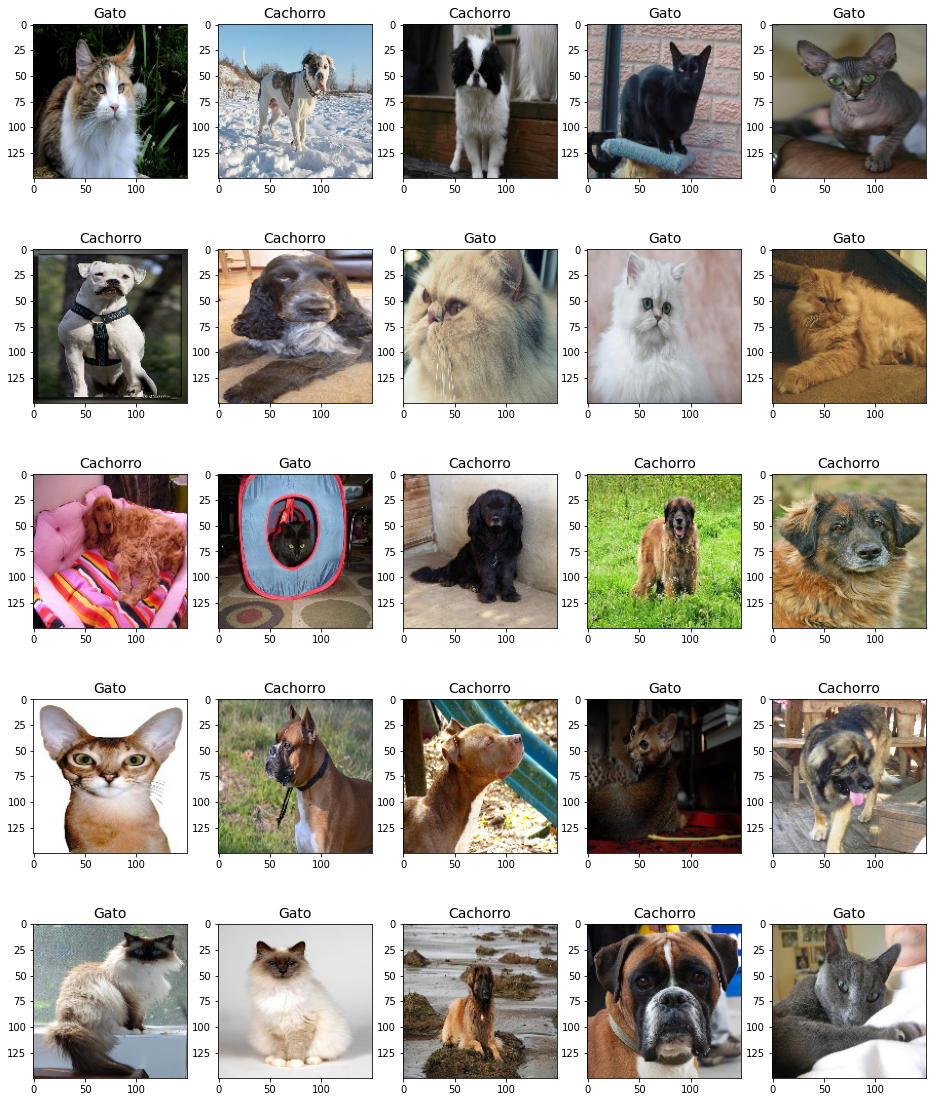

In [17]:
n_rows = 5
n_cols = 5
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16,20))

i = 0
for batch in val_generator:
    inputs, outputs = batch

    for j in range(n_cols):
        imagem = inputs[j]
        classe = outputs[j]
        
        axs[i][j].imshow(imagem, vmin=0, vmax=1)
        axs[i][j].set_title( idx_to_class_dict[classe], size=14)
    
    i += 1
    if i == n_rows:
        break

In [18]:
inputs[j]

array([[[0.57254905, 0.49803925, 0.32941177],
        [0.5411765 , 0.48235297, 0.32941177],
        [0.5647059 , 0.5019608 , 0.36078432],
        ...,
        [0.7686275 , 0.61960787, 0.54509807],
        [0.7490196 , 0.6       , 0.5254902 ],
        [0.7254902 , 0.5803922 , 0.50980395]],

       [[0.5686275 , 0.49411768, 0.3254902 ],
        [0.5764706 , 0.5058824 , 0.35686275],
        [0.5176471 , 0.454902  , 0.3137255 ],
        ...,
        [0.7725491 , 0.62352943, 0.54901963],
        [0.7568628 , 0.60784316, 0.53333336],
        [0.74509805, 0.59607846, 0.52156866]],

       [[0.6039216 , 0.5294118 , 0.36078432],
        [0.56078434, 0.4901961 , 0.34117648],
        [0.43921572, 0.36862746, 0.21960786],
        ...,
        [0.7843138 , 0.62352943, 0.5529412 ],
        [0.7686275 , 0.60784316, 0.5372549 ],
        [0.75294125, 0.5921569 , 0.52156866]],

       ...,

       [[0.03137255, 0.03137255, 0.02352941],
        [0.04313726, 0.04313726, 0.03529412],
        [0.05882353, 0

In [19]:
outputs[j]

1.0

<font color = 'red'>

**Comentário:**

Dos objetos retornados pelo generator, os valores dos pixels foram normalizados para uma faixa específica, que foi entre 0 e 1. O inputs[j] representam os valores de cada pixel de uma determinada imagem e o outputs[j] a sua classe.
    
Sim, é possível.
    
Se não utilizar o break, acontece erro, já que ele sai do loop for quando todas as colunas que separamos para plotagem são preenchidas.
 
</font>

### 1.2. Aumento de Dados

Outras transformações possíveis no ImageDataGenerator viabilizam o aumento de dados. Nesse sentido, é possível definir transformações aleatórias que são realizadas conforme os dados são carregados para simular um banco de dados maior.

* Exemplos de transformações aleatórias são:
    * rotation_range valor que define o valor máximo (em graus) das rotações aleatórias realizadas;
    * width_shift_range valor (em fração) que determina o valor máximo de uma translação horizontal realizada com base na largura da imagem;
    * height_shift_range valor (em fração) que determina o valor máximo de uma translação vertical realizada com base na altura da imagem;
    * zoom_range valor (em fração) que determina o maior zoom aleatório realizado na imagem;
    * shear_range valor (em fração) que determina a maior deformação aleatória realizada na imagem;
    * horizontal_flip booleano que determina se reflexões horizontais devem ser aplicadas aleatoriamente na imagem;
    * vertical_flip booleano que determina se reflexões verticais devem ser aplicadas aleatoriamente na imagem;
    * fill_mode modo de preenchimento de buracos provocados pelas transformações realizadas:
        * 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
        * 'nearest': aaaaaaaa|abcd|dddddddd
        * 'reflect': abcddcba|abcd|dcbaabcd
        * 'wrap': abcdabcd|abcd|abcdabcd
        
* Mais informações em https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [20]:
train_datagen = ImageDataGenerator( rescale = 1./255,           #
                                    rotation_range = 45,        # Rotação aleatória de até 40°
                                    width_shift_range = 0.2,    # Translação horizontal de até 20% da largura
                                    height_shift_range = 0.2,   # Translação vertical de até 20% da altura
                                    zoom_range = 0.2,           # Zoom aleatório de até 20%
                                    shear_range=0.2,            # Deformação de 20%
                                    horizontal_flip = True,     # Espelhamento horizontal aleatório
                                    vertical_flip = False,      # Espelhamento vertical aleatório
                                    fill_mode = "nearest")      # Preenchimentod e buracos pelo pixel mais próximo

train_generator = train_datagen.flow_from_directory( os.path.join(".", "data", "train"), target_size = (150, 150),
                                                     batch_size  = 20, class_mode  = "binary")

# Atributo do generator que fornece o número de amostras detectadas
train_samples = train_generator.samples 
print(train_samples)

Found 2000 images belonging to 2 classes.
2000


**b. O código abaixo itera o generator produzido para plotar imagens do banco de dados com aumento de dados. Analise as imagens produzidas e comente:**

* Qual o impacto do aumento de dados sobre o treinamento dos modelos?
* As transformações realizadas podem alterar os gabaritos nesse banco de dados?
* Em um caso geral, que tipo de cuidados devem ser tomadas para que os gabaritos do banco de dados não sejam alterados?

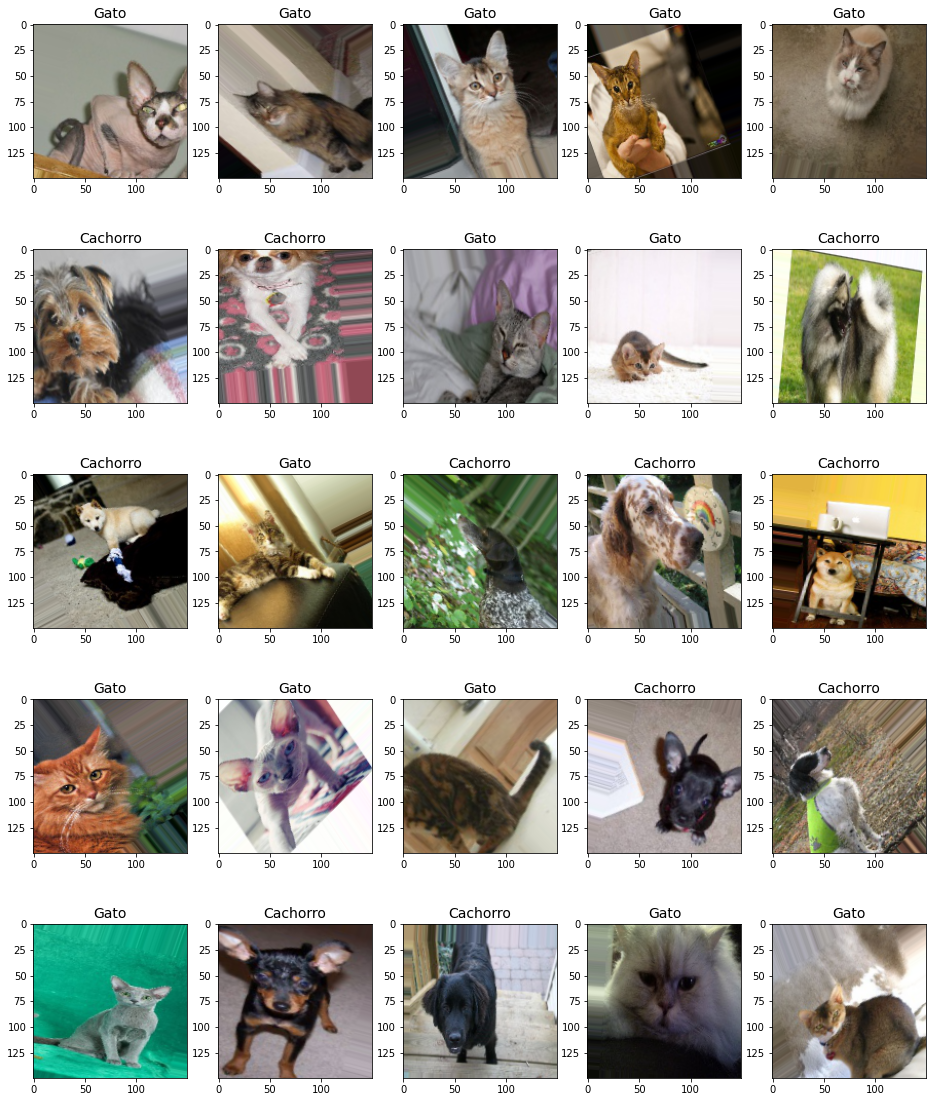

In [21]:
n_rows = 5
n_cols = 5
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16,20))

i = 0
for batch in train_generator:
    inputs, outputs = batch

    for j in range(n_cols):
        imagem = inputs[j]
        classe = outputs[j]
        
        axs[i][j].imshow(imagem, vmin=0, vmax=1)
        axs[i][j].set_title( idx_to_class_dict[classe], size=14)
    
    i += 1
    if i == n_rows:
        break

<font color = 'red'>

**Comentário:**

O aumento do banco de dados é crucial quando se trata de poucas imagens, já que quanto maior o banco de dados mais a rede será capaz de lidar com determinadas situações.

No nosso, os nossos gabaritos não são alterados. Mas em outros casos como por exemplo, um algoritmo que informe a direção que determinado objeto aponta, o gabarito seria alterado pela rotação.
   
</font>

## 2. Construindo o Modelo

* Dessa vez o modelo utilizado será construído com base em Transferência de Aprendizado:
    * Isso quer dizer que vamos carregar os pesos de uma CNN já treinada para outra tarefa e utilizá-la na classificação de cães e gatos;
    * Vamos utilizar o modelo VGG16, que está disponível internamente ao Keras por meio do módulo keras.applications.
    * O modelo pode ser instanciado de forma semelhante a uma camada, utilizando **conv_base = VGG16(include_top, weights, input_shape)**
        * conv_base é a variável que referencia a "camada" criada;
        * include_top é uma variável booleana que determina se as camadas totalmente conectadas da rede também devem ser carregadas (True) ou não (False). Isso raramente é feito em casos de transferência de aprendizagem porque essas camadas não tendem a ser muito generalizáveis.
        * weights indica os pesos que devem ser carregados com a arquitetura, **None** indica para carregar a rede com pesos aleatórios e **"imagenet"** indica para carregar a rede pré-treinada no banco de imagens da ImageNet;
        * input_shape é o formato da entrada da rede. Dependendo do formato especificado talvez não existam pesos pré-treinados para carregar;
    * Vamos utilizar a rede pré-treinada com pesos do ImageNet, que é um banco de dados com milhões de imagens para classificação de objetos em 1000 classes diferentes. 
        * Esse tipo de treinamento é realizado para produzir modelos com filtros generalizáveis que possam ser reaproveitados em um esquema de transferência de aprendizagem como este;
        * A VGG16 com esses pesos alcança uma taxa de acurácia superior a 70% no ImageNet, o que é uma performance considerável tendo em vista que existem 1000 classes distintas;


* Mais informações sobre os modelos pré-treinados disponíveis: https://keras.io/api/applications/

### 2.1. Base Convolucional da VGG16

**a. O código abaixo carrega a base convolucional da rede VGG16 e printa o resumo do modelo. Comente:**

* A estratégia empregada por essa arquitetura é semelhante à que foi utilizada no Exp.7?
* Quais as principais diferenças e semelhanças entre a base convolucional da VGG16 e a CNN produzida no Exp.7?

In [28]:
def print_vgg16_summary( shape ):
    conv_base = VGG16(include_top = False, weights = None, input_shape = shape)
    print( conv_base.summary() )
    return

print_vgg16_summary( shape = (150, 150, 3) )

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

<font color = 'red'>

**Comentário:**

A estratégia é semelhante na utilização das sequencias Conv2D e MaxPooling, porém o Exp.7 faz a utilização do Dropout podendo ser uma medida para evitar o overfitting, e também do Flatten que é o preparo para entrar na última camada da rede com as camadas Dense com ativação Relu e softmax, que não são utilizadas no EXP.8.
    
</font>

### 2.2. Congelando Camadas

No Keras, camadas de uma rede podem ter seus pesos congelados, fazendo com que eles não sejam modificados durante o treinamento. 

* Para fazer isso, basta selecionar uma camada e modificar seu atributo **trainable** para False.
* Em contrapartida, para descongelar uma camada basta alterar o mesmo atributo para True.

**b. O código abaixo constrói uma arquitetura a partir da base convolucional da rede VGG16, mas adiciona novas camadas densas ao final. Comente:**

* Qual a importância de congelar os pesos da base convolucional?
* Todas as camadas desse modelo possuem pesos pré-treinados? Em caso negativo, como são definidos os demais pesos?
* Nesse caso, seria possível utilizar uma ativação "softmax" na saída? Se isso fosse feito, seria necessário realizar alguma alteração no ImageDataGenerator? E na função de perdas?

In [29]:
def build_model( input_shape, n_outputs ):
    # Base convolucional
    conv_base = VGG16(include_top = False, weights = "imagenet", input_shape = input_shape)
    conv_base.trainable = False
    
    rede = Sequential()
    rede.add( conv_base )
    rede.add( layers.Flatten() )
    rede.add( layers.Dense( 256, activation = "relu" ) )
    rede.add( layers.Dense(   1, activation = "sigmoid" ) )
    
    return rede

model = build_model( (150, 150, 3), 1 )
model.compile(optimizer=optimizers.Adam(lr=1e-4), 
              loss="binary_crossentropy", 
              metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


<font color = 'red'>

**Comentário:**

Um motivo para congelar os pesos da base, seria para evitar o overfitting, já que assim não aconteceria o sobre ajuste. 
   
Não, como podemos observar, foi adicionado as camadas Flatten e Dense. Ficando mais semelhante com o Exp.7.
    
Sim, seria possível. Precisaria fazer alguns ajustes, já que a softmax é ideal para lidar com mais de um gabarito e no caso definimos ele como binário.
    
</font>

## 3. Treinando o Modelo

### 3.1. Callbacks

* Dessa vez utilizaremos uma nova callback do Keras, o ReduceLROnPlateau.
* Essa função modifica a taxa de aprendizagem utilizada durante o treinamento caso a variável monitorada deixe de melhorar por um número pré-definido de epochs.
* reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(monitor, factor, patience, verbose)
    * monitor é a variável que deve ser monitorada pelo callback;
    * factor é a constante que deve ser multiplicada pela taxa de aprendizagem atual caso um ajuste seja realizado;
    * patience é o número de epochs sem melhora que devem ocorrer para que um ajuste na taxa de aprendizagem seja realizado;
    * verbose é o modo de texto, 1 indica para que o Keras avise quando um novo modelo for salvo;
    
    
* Lista de callbacks disponíveis: https://keras.io/api/callbacks/

In [30]:
model_checkpoint = callbacks.ModelCheckpoint("model.h5", monitor = "val_acc", save_best_only = True, verbose = 1)
reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(monitor = "val_acc", factor = 0.75, patience = 3, verbose = 1)

# Repare que ao utilizar mais de 1 callback elas devem ser organizadas em uma lista
callback_list = [model_checkpoint, reduce_lr_on_plateau]

### 3.2. Ajuste dos Pesos

O treinamento é realizado a partir da função **fit**, que recebe dados de treino e de validação além de hiperparâmetros como o número de épocas e o tamanho dos lotes de dados (batchsize). Nesse caso, como estamos utilizando generators, não é preciso fornecer os exemplos e os gabaritos separadamente e nem o batchsize:

* **hist = model.fit( x = None, steps_per_epoch = None, epochs = 1, callbacks = [], validation_data = None, validation_steps = None, verbose = "auto")**
    * x corresponde aos dados de treino, também pode ser um generator;
    * steps_per_epoch corresponde ao número de lotes (batches) que devem ser produzidos com o generator de treino por epoch;
    * epochs corresponde ao número de épocas de treinamento;
    * callbacks corresponde à lista de callbacks utilizada;
    * validation_data corresponde aos dados de validação, também pode ser um generator;
    * validation_steps corresponde ao número de lotes (batches) que devem ser produzidos com o generator de validação por epoch;
    * verbose indica como a função deve reportar os resultados:
        * 0: modo silencioso, nenhum retorno em formato de texto;
        * 1: retorno a cada época e barra de progresso;
        * 2: retorno a cada época sem barra de progresso;
    * hist é um dicionário de retorno com os valores de loss e das métricas computadas para treino e validação;

In [31]:
history = model.fit( train_generator, steps_per_epoch = 100,
                     epochs = 30, callbacks = callback_list, 
                     validation_data = val_generator, validation_steps = 50 )

model.load_weights("model.h5")

history_dict = history.history

Epoch 1/30
100/100 [==============================] - 23s 225ms/step - loss: 0.5183 - acc: 0.7280 - val_loss: 0.3541 - val_acc: 0.8260

Epoch 00001: val_acc improved from -inf to 0.82600, saving model to model.h5
Epoch 2/30
100/100 [==============================] - 22s 223ms/step - loss: 0.4174 - acc: 0.8020 - val_loss: 0.3022 - val_acc: 0.8690

Epoch 00002: val_acc improved from 0.82600 to 0.86900, saving model to model.h5
Epoch 3/30
100/100 [==============================] - 22s 224ms/step - loss: 0.3810 - acc: 0.8325 - val_loss: 0.2848 - val_acc: 0.8800

Epoch 00003: val_acc improved from 0.86900 to 0.88000, saving model to model.h5
Epoch 4/30
100/100 [==============================] - 22s 224ms/step - loss: 0.3455 - acc: 0.8460 - val_loss: 0.2654 - val_acc: 0.8830

Epoch 00004: val_acc improved from 0.88000 to 0.88300, saving model to model.h5
Epoch 5/30
100/100 [==============================] - 22s 224ms/step - loss: 0.3602 - acc: 0.8405 - val_loss: 0.2930 - val_acc: 0.8850

Epo

### 3.3. Resultados

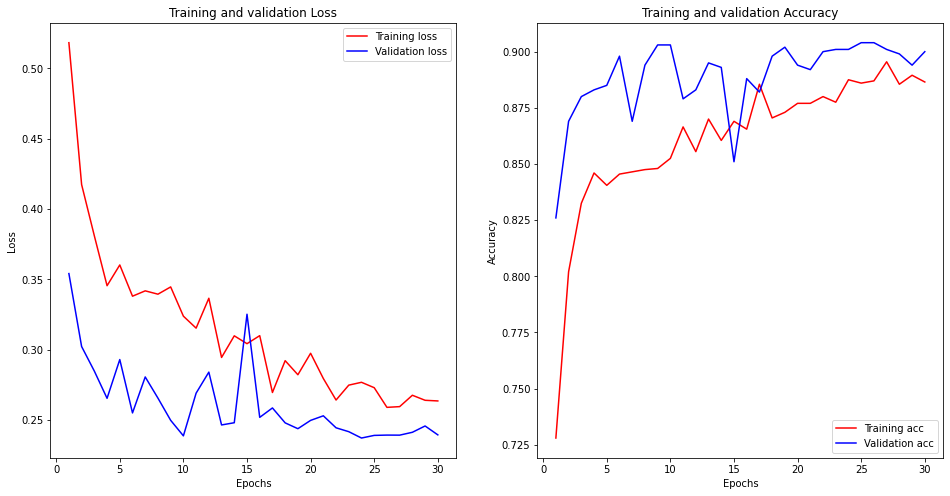

In [32]:
fig, axes = plt.subplots(1, 2, squeeze = False, figsize = (16,8))

# Loss
train_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

# Epochs
epochs = range(1, len(train_loss_values) + 1)

# Accuracy
train_acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

ax = axes.flat[0]
ax.plot(epochs, train_loss_values, "r", label="Training loss")
ax.plot(epochs, val_loss_values, "b", label="Validation loss")
ax.set_title("Training and validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

ax = axes.flat[1]
ax.plot(epochs, train_acc_values, "r", label="Training acc")
ax.plot(epochs, val_acc_values, "b", label="Validation acc")
ax.set_title("Training and validation Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()

## 4. Teste do Modelo

### 4.1. Métricas

O teste do modelo pode ser realizado a partir da função **evaluate**, que também suporta generators.

* Observe que dessa vez utilizou-se o parâmetro "shuffle" no flow_from_directory. Isso foi feito para que os exemplos de teste não fossem embaralhados pelo generator e pudessem ser identificados posteriormente.

**a. O uso de uma rede pré-treinada melhorou a qualidade do modelo produzido? Reinicie a VGG16 com pesos aleatórios e compare as taxas de acerto obtidas.**

In [33]:
test_datagen   = ImageDataGenerator( rescale = 1./255 )
test_generator = test_datagen.flow_from_directory( os.path.join(".", "data", "test"), target_size = (150, 150),
                                                   batch_size  = 1, class_mode  = "binary", shuffle = False)

# Atributo do generator que fornece o número de amostras detectadas
test_samples = test_generator.samples

test_loss, test_acc = model.evaluate( test_generator )

print("Test Accuracy:", 100*test_acc, "%")
print("Acertos: {} - Erros: {}".format(round(test_samples * test_acc), 
                                       round(test_samples * (1-test_acc) )))

Found 1000 images belonging to 2 classes.
1000/1000 [==============================] - 21s 20ms/step - loss: 0.2582 - acc: 0.8950
Test Accuracy: 89.49999809265137 %
Acertos: 895 - Erros: 105


<font color = 'red'>

**Comentário:**

Melhorou, já que quando reiniciamos com os pesos aleatórios as taxas de acertos diminuíram, ficando com 105 erros, sendo que com a rede pré-treinada foram de 100. 
    
</font>

### 4.2. Visualização dos Resultados

**b. Verifique os casos de erro do modelo e comente se é possível identificar algum padrão nos erros e/ou acertos do modelo.**

In [34]:
def show_results(paths, ytest, ypred, labels, num = 25, tipo = "rand"):
    
    if tipo == "acertos":
        fltr_idx = [i for i in range(ytest.shape[0]) if ypred[i] == ytest[i]]
    else:
        fltr_idx = [i for i in range(ytest.shape[0]) if ypred[i] != ytest[i]]
        
    indices = np.random.choice(fltr_idx, min(num, len(fltr_idx)), replace=False)
       
    rows = int(num/5)
    fig, axs = plt.subplots(nrows = rows, ncols = 5, figsize=(20, 5*rows))
    
    for i, idx in enumerate(indices):
        path = os.path.join(".", "data", "test", paths[idx])
        img = cv2.imread(path)[:,:,::-1]
        if ypred[idx] == ytest[idx]:
            axs[i//5][i%5].set_title(labels[ytest[idx]], color = "green", fontsize = 20)
        else:
            axs[i//5][i%5].set_title("Pred: {}\n Gabarito: {}".format(labels[ypred[idx]], 
                                                                      labels[ytest[idx]]), color = "red", fontsize = 20)
        
        axs[i//5][i%5].imshow(img, vmin=0, vmax=255, cmap = "gray")
    return

test_generator.reset()
filenames = test_generator.filenames
labels = test_generator.labels

pred_labels = model.predict(test_generator, verbose=1)
preds = [int(pred[0] > 0.5) for pred in pred_labels]

1000/1000 [==============================] - 17s 17ms/step


#### Acertos

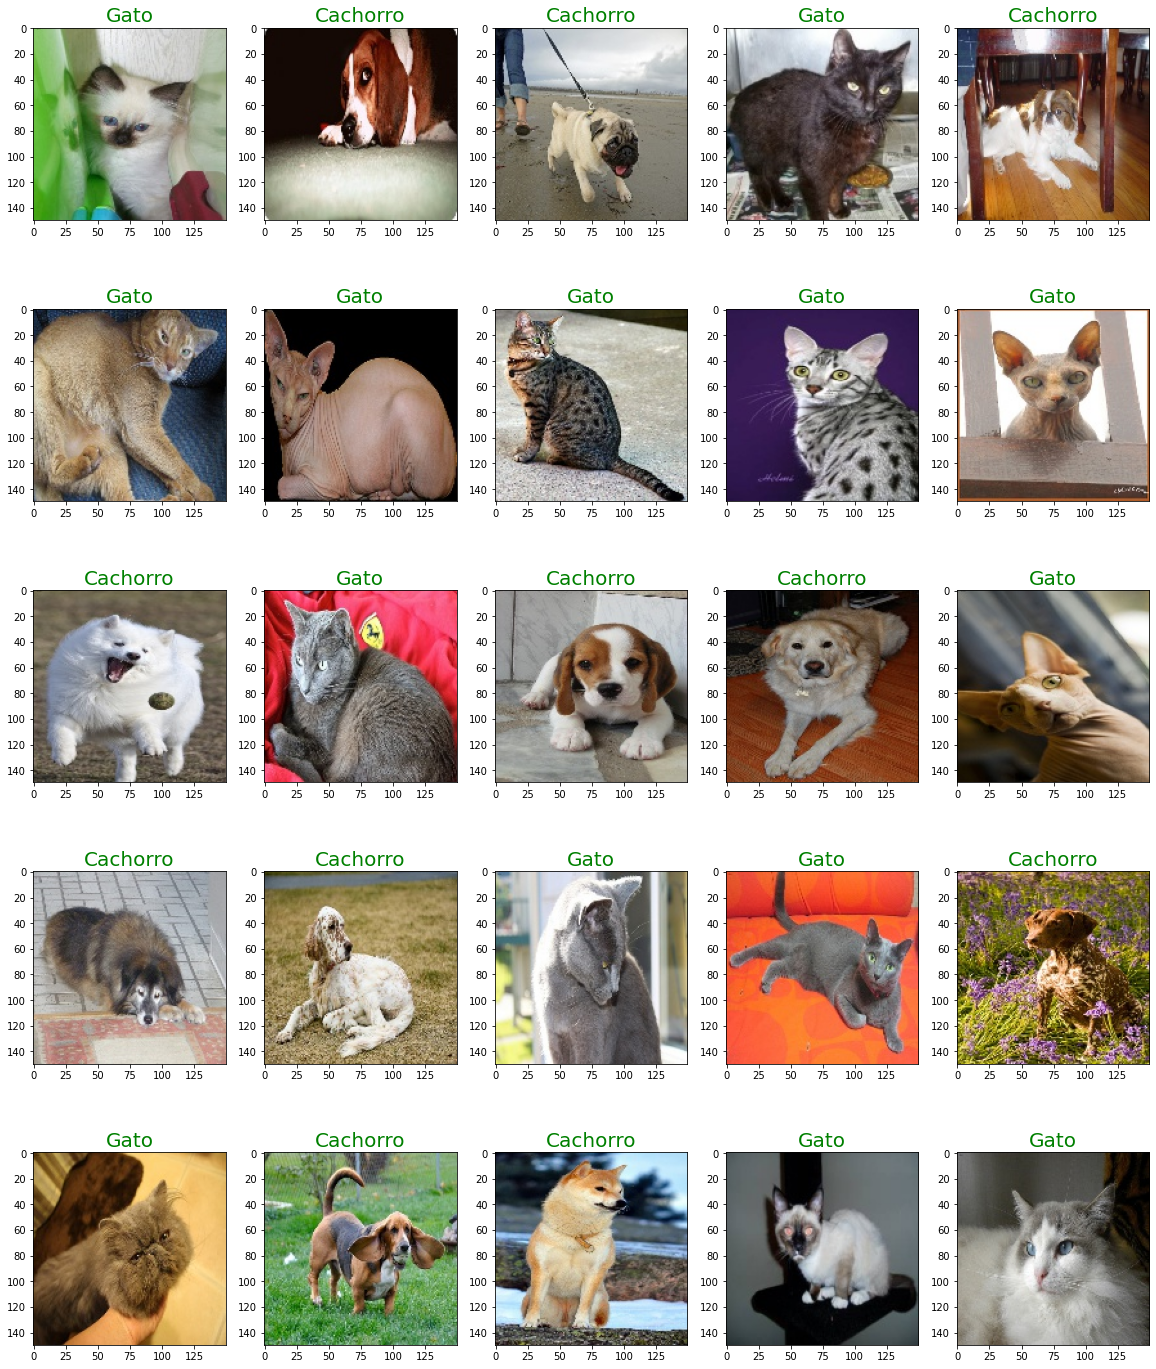

In [35]:
show_results(filenames, labels, preds, idx_to_class_dict, tipo = "acertos")

#### Erros

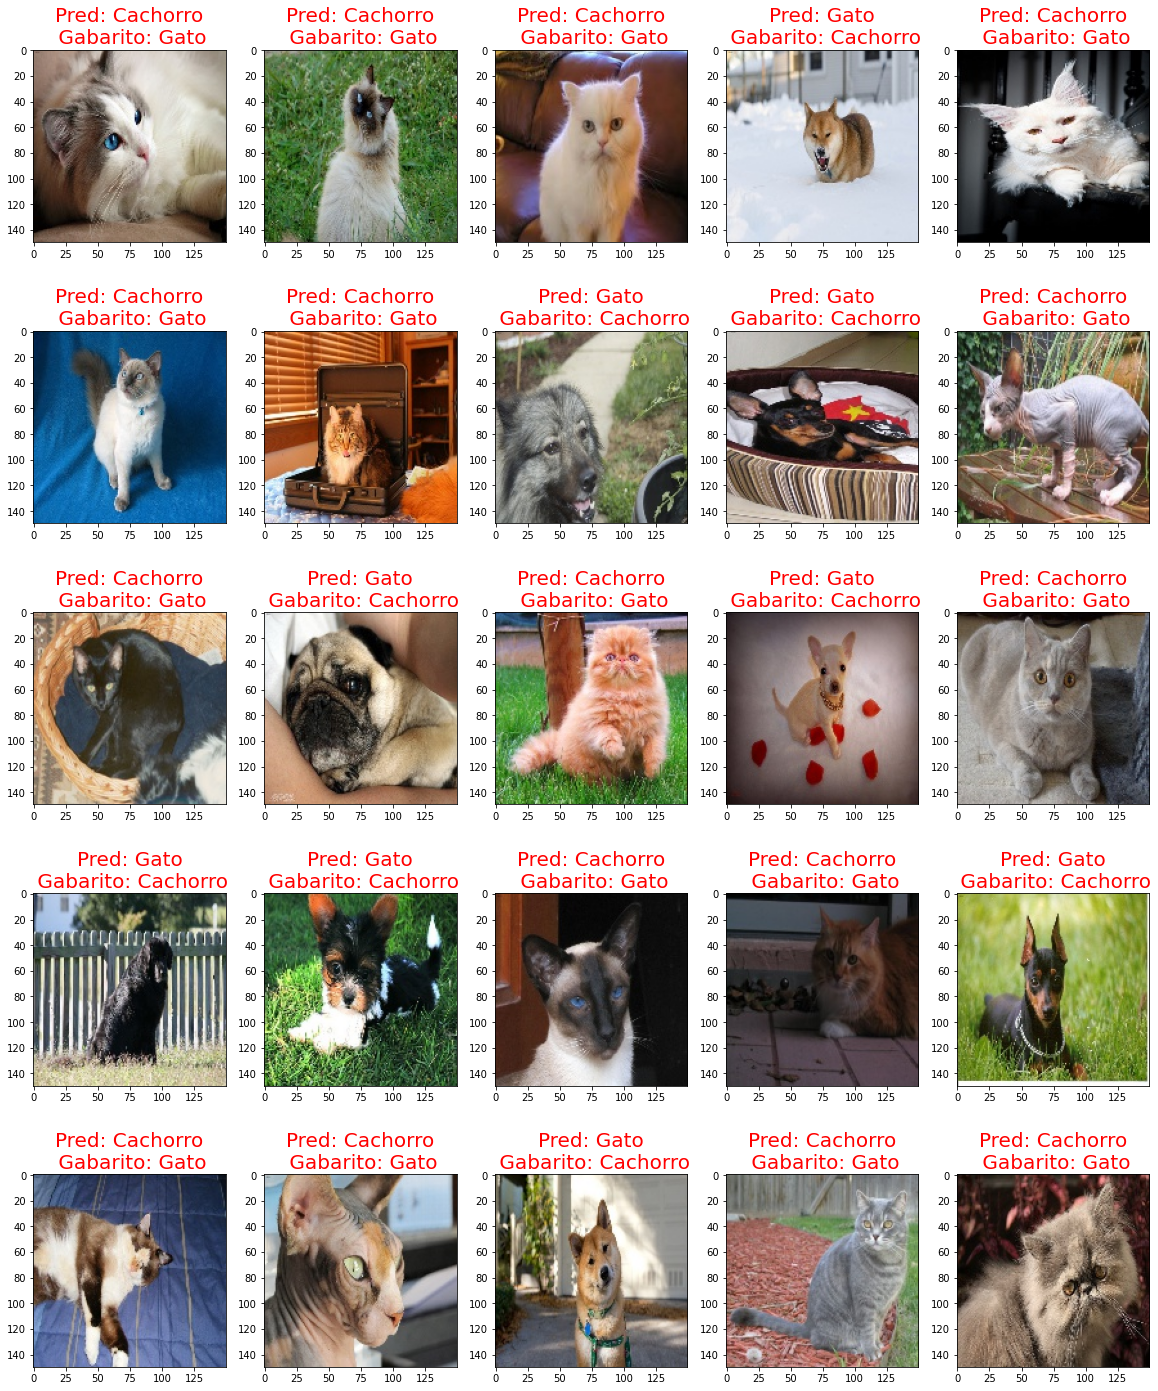

In [36]:
show_results(filenames, labels, preds, idx_to_class_dict, tipo = "erros")

<font color = 'red'>

**Comentário:**

A rede não soube lidar muito bem com os cachorros de orelhas levantadas.

</font>